# Supervised Learning of Keywords using fastText
## Text Classification
The goal of text classification is to assign documents (such as emails, posts, text messages, product reviews, etc...) to one or multiple categories. Such categories can be review scores, spam v.s. non-spam, or the language in which the document was typed. Nowadays, the dominant approach to build such classifiers is machine learning, that is learning classification rules from examples. In order to build such classifiers, we need labeled data, which consists of documents and their corresponding categories (or tags, or labels).

As an example, we build a classifier which automatically classifies ONS publications by their supplied keywords.

In [1]:
import fastText
import gensim
import os

In [2]:
if os.path.isdir("./models/") is False:
    !mkdir models

# Corpa
To create the text corpus, we load in articles and bulletins published on the ONS website. The final corpus consists of sentences found in the pages summaries and markdown sections, tagged by the keywords provided with each page.

For the purpose of this notebook, we have stored all artices and bulletins in a local mongoDB database for painless retrieval. Lets define some functions for loading the pages as json below.

In [3]:
def getMongoDBClient(mongoUrl, port):
    from pymongo import MongoClient
    return MongoClient(mongoUrl, port)

def load_pages(use_mongo=True):
    # Load pages from disk/mongo
    pages = None
    print "Loading pages from " + "mongoDB" if use_mongo else "filesystem"
    if (use_mongo):
        mongoClient = getMongoDBClient("localhost", 27017)
        collection = mongoClient.local.pages

        query = {
            "sections": {
                "$exists": True
            }
        }
        cursor = collection.find(query)

        pages = []
        for doc in cursor:
            pages.append(doc)
    else:
        # Read from filesystem
        from modules.ONS.file_scanner import FileScanner
        scanner = FileScanner()
        pages = scanner.load_pages()
    print "Done"
    return pages

In [4]:
pages = load_pages(use_mongo=True)
print "Loaded %d pages" % (len(pages))

Loading pages from mongoDB
Done
Loaded 1960 pages


# Test processing
To give our model the best chance of accurate classifications, we should clean up the raw text keywords to remove things like stop words etc. Below we define some basic utility functions to clean raw text, then process the pages we just loaded in.

In [5]:
from gensim.utils import lemmatize
from nltk.corpus import stopwords

def get_stopwords():
    return set(stopwords.words('english'))  # nltk stopwords list

def get_bigram(train_texts):
    import gensim
    bigram = gensim.models.Phrases(train_texts)  # for bigram collocation detection
    return bigram

def build_texts_from_file(fname):
    import gensim
    """
    Function to build tokenized texts from file
    
    Parameters:
    ----------
    fname: File to be read
    
    Returns:
    -------
    yields preprocessed line
    """
    with open(fname) as f:
        for line in f:
            yield gensim.utils.simple_preprocess(line, deacc=True, min_len=3)

def build_texts_as_list_from_file(fname):
    return list(build_texts_from_file(fname))

def build_texts(texts):
    import gensim
    """
    Function to build tokenized texts from file
    
    Parameters:
    ----------
    fname: File to be read
    
    Returns:
    -------
    yields preprocessed line
    """
    for line in texts:
        yield gensim.utils.simple_preprocess(line, deacc=True, min_len=3)

def build_texts_as_list(texts):
    return list(build_texts(texts))

def process_texts(texts, stops=get_stopwords()):
    """
    Function to process texts. Following are the steps we take:
    
    1. Stopword Removal.
    2. Collocation detection.
    3. Lemmatization (not stem since stemming can reduce the interpretability).
    
    Parameters:
    ----------
    texts: Tokenized texts.
    
    Returns:
    -------
    texts: Pre-processed tokenized texts.
    """
    bigram = get_bigram(texts)

    texts = [[word for word in line if word not in stops] for line in texts]
    texts = [bigram[line] for line in texts]
    
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()

    texts = [[word for word in lemmatizer.lemmatize(' '.join(line), pos='v').split()] for line in texts]
    return texts

In [6]:
import os, re

ons_ft = gensim.models.KeyedVectors.load_word2vec_format("models/ons_ft.vec")

def parse_corpus(content, stop=None):
    # Convert 'content' into properly formatted text corpus with stop word removal

#     print "Parsing text corpus..."

    stop = get_stopwords()
    texts = build_texts_as_list(content)
    texts = process_texts(texts, stops=stop)

#     print "Done"
    return texts

def generate_corpus(pages):
    # Gather some human written text into 'content'
    import markdown
    from string import punctuation
    from bs4 import BeautifulSoup
    from nltk.tokenize import sent_tokenize

    print "Generating text corpus..."

    pattern = "[, \-!?:]+"

    fix_encoding = lambda s: s.decode('utf8', 'ignore')

    def strip_punctuation(s):
        return ''.join(c for c in s if c not in punctuation)

    def markdown_to_text(md):
        extensions = ['extra', 'smarty']
        html = markdown.markdown(md, extensions=extensions, output_format='html5')
        soup = BeautifulSoup(html, "lxml")
        return soup.text
    
    def get_keywords(description):
        keywords = []
        for keyword in description["keywords"]:
            keyword = keyword.lower().strip().replace(" " , "_")
            if "," in keyword:
                keywords.extend([k.lower().strip().replace(" " , "_") for k in keyword.split(",")])
            else:
                keywords.append(keyword)
        return keywords
    
    def proceed(page):
        if "description" in page \
                and "keywords" in page["description"] \
                and len(page["description"]["keywords"]) > 0:
#             for keyword in get_keywords(page["description"]):
#                 valid = re.match('^[\w-]+$', keyword) is not None
#                 if not valid:
#                     return False
#                 if keyword not in ons_ft.wv.vocab:
#                     return False
            return True
        return False
    
    def process_text(text, corpus, min_sent_length=4):
        sentences = sent_tokenize(text)
        for sentence in sentences:
            tokens = sentence.split()
            if len(tokens) >= min_sent_length:
                doc = {"text": sentence, "keywords": keywords}        
                corpus.append(doc)
                
    from progressbar import ProgressBar
    pbar = ProgressBar()

    corpus = []
    for page in pbar(pages):
        if proceed(page):
            description = page["description"]
            keywords = get_keywords(description)
            
            text = description["title"]
#             process_text(text, corpus)
                
            if "summary" in description:
                text = description["summary"]
                process_text(text, corpus)
            if "sections" in page:
                for section in page["sections"]:
                    if "title" in section:
                        text = section["title"]
                        process_text(text, corpus)
                    if "markdown" in section:
                        text = markdown_to_text(section["markdown"])
                        process_text(text, corpus)
                
            
    print "Done"
    return corpus

In [7]:
import pickle
import numpy as np
do_load=False

if do_load:
    with open("./raw_corpus.p", "rb") as f:
        corpus = pickle.load(f)
else:
    corpus = generate_corpus(pages)
    pickle.dump(np.array(corpus), open("./raw_corpus.p", "wb"))
print len(corpus)

Generating text corpus...


100% |########################################################################|


Done
232647


# Writing the training set
The final step is to write the training data out in the correct format. We prepend a prefix to each label, so the classifier knows how to identify them aside from the raw text corpus.

In [8]:
# import random

# random.shuffle(corpus)

# stops = []

# token_threshold = 20

# size_train = int(np.round(len(corpus) * (3./4.)))
# train_corpus = corpus[:size_train]
# valid_corpus = corpus[size_train:]

# with open("train.txt", "w") as f:
#     for i in range(len(train_corpus)):
#         text = train_corpus[i]["text"].strip()
#         text = process_texts([text.split()], stops=stops)[0]
        
#         ntokens = len(text)
        
#         if ntokens > token_threshold:
#             text = " ".join(text)
#             if text.endswith(".") is False:
#                 text += " <eos>"
#             else:
#                 text = "%s <eos>" % text[:-1]

#             s = re.sub( '\s+', ' ', text.encode("ascii", "ignore") ).strip()
#             if i < len(train_corpus) - 1:
#                 s = "%s\n" % s
#             f.write(s)
        

# with open("valid.txt", "w") as f:
#     for i in range(len(valid_corpus)):
#         text = valid_corpus[i]["text"].strip()
#         text = process_texts([text.split()], stops=stops)[0]
        
#         ntokens = len(text)
        
#         if ntokens > token_threshold:
#             text = " ".join(text)
#             if text.endswith(".") is False:
#                 text += " <eos>"
#             else:
#                 text = "%s <eos>" % text[:-1]

#             s = re.sub( '\s+', ' ', text.encode("ascii", "ignore") ).strip()
#             if i < len(valid_corpus) - 1:
#                 s = "%s\n" % s
#             f.write(s)
        
# !cp train.txt test.txt

In [19]:
stops = []

from progressbar import ProgressBar
pbar = ProgressBar()

with open("./ons_corpus.txt", "w") as f:
    for d in pbar(corpus):
        text = d["text"].strip()
        s = re.sub( '\s+', ' ', text.encode("ascii", "ignore") ).strip()
        s = s.split()
        if len(s) > 10:
            s = process_texts([s], stops=stops)[0]
            s = " ".join(s)
            
            if s.endswith(".") is False:
                s = s + "."
        
            f.write(s + "\n")
        

100% |########################################################################|


In [9]:
# stops = get_stopwords()
# stops.append(".")
stops = []

def label_sentence(text, labels, label_prefix="__label__"):
    
    try:
        labels = filter(None, process_texts([labels], stops=stops))[0]
        labels = [l for l in labels if l in ons_ft.wv.vocab]

        if len(labels) > 0:
            labels = set( ["%s%s" % (label_prefix, l) for l in labels] )
            joined_labels = " ".join(labels)

            text = process_texts([text.split()], stops=stops)[0]
            text = " ".join(text)
            if text.endswith(".") is False:
                text += "."

            return "%s %s" % (joined_labels, text)
    except IndexError as e:
        pass
    return None

print "Processing %d items in corpus" % len(corpus)

from progressbar import ProgressBar
pbar = ProgressBar()

lines = []
for d in pbar(corpus):
    text = d["text"].strip()
    keywords = d["keywords"]
    line = label_sentence(text, keywords)
    if line is not None:
        lines.append(line.lower())
    
# Shuffle the list
import random
random.shuffle(lines)

Processing 232647 items in corpus


/Users/sullid/anaconda2/lib/python2.7/site-packages/gensim/models/phrases.py:486: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
100% |########################################################################|


In [10]:
print len(lines)
print lines[0]

222726
__label__debt_burden __label__pension individuals aged 35 to 44 indicating that they have the heaviest debt burden (22.8%) and the highest reports of somewhat of a burden (38.9%).


# Training and Validation Data
In order to test the accuracy of our model, we purposely keep part of the training data back as a validation dataset by splitting the corpus into two files, with extendions ".train" and ".valid".

In [12]:
import numpy as np

def write_corpus(full_corpus, prefix):
    """
    Splits the corpus into training (.train) and validation (.valid) datasets
    """    
    size_train = int(np.round(len(full_corpus) * (3./4.)))
    train_corpus = full_corpus[:size_train]
    valid_corpus = full_corpus[size_train:]
    
    print len(train_corpus)
    print len(valid_corpus)
    
    extensions = [".train", ".valid", ""]
    corpa = [train_corpus, valid_corpus, full_corpus]
    
    for ext, cps in zip(extensions, corpa):
        fname = "%s_labelled.txt%s" % (prefix, ext)
        with open(fname, "w") as f:
            for s in cps:
                if len(s) > 0:
                    s = re.sub( '\s+', ' ', s.encode("ascii", "ignore") ).strip()
                    f.write("%s\n" % s)

# if os.path.isfile(corpus_fname) is False:
write_corpus(lines, "ons")
print "Corpa written to file."

167044
55682
Corpa written to file.


In [ ]:
# Train the model
import fastText
print "Training..."
model = fastText.train_supervised(input="ons_labelled.txt.train", label="__label__",\
                          dim=300, epoch=1000, wordNgrams=2, verbose=2, minCount=15,\
                          minCountLabel=5, lr=0.1, neg=10, thread=16, loss="ns", t=1e-5)
model.save_model("models/ons_supervised.bin")
print "Done"

# Testing
To test the model, we use the validation training set to try and predict the top 'k' labels. The output of the below test are the precision at k=1 (P@1) and the recall at k=1 (R@1):

In [1]:
import fastText

model = fastText.load_model("models/ons_supervised.bin")

In [ ]:
# Test the model
k=1
N, P, R = model.test("ons_labelled.txt.valid", k)
print "Total number of samples=", N
print "P@%d=" % k, P
print "R@%d=" % k, R

We can also compute the precision and recall at k=5 with:

In [ ]:
# Test the model
k=5
N, P, R = model.test("ons_labelled.txt.valid", k)
print "Total number of samples=", N
print "P@%d=" % k, P
print "R@%d=" % k, R

In [ ]:
# Test the model
k=10
N, P, R = model.test("ons_labelled.txt.valid", k)
print "Total number of samples=", N
print "P@%d=" % k, P
print "R@%d=" % k, R

In [ ]:
# Example output
k = 10
label_prefix = "__label__"
labels, probs = model.predict("UKs shortfall to Germany".lower(), k)
for label,prob in zip(labels, probs):
    print "%s:%f" % (label.replace(label_prefix, ""), prob)

In [2]:
# Reduce memory usage of model and save

# Use PCA to reduce size of input and output matricies
from sklearn import decomposition
pca = decomposition.PCA(n_components=50)

im = model.get_input_matrix()
om = model.get_output_matrix()

pca_fit_im = pca.fit(im)
im_transformed = pca_fit_im.transform(im)

pca_fit_om = pca.fit(om)
om_transformed = pca_fit_om.transform(om)

for fname, arr in zip(["ons_supervised_quantized.bin.im_reduced", "ons_supervised_quantized.bin.om_reduced"], [im_transformed, om_transformed]):
    with open(fname, "wb") as f:
        arr.dump(f)

model.quantize()
model.save_model("models/ons_supervised_quantized.bin")

In [5]:
import pickle
with open("ons_supervised_quantized.bin.im_pca", "wb") as f:
    pickle.dump(pca_fit_im, f)
    
with open("ons_supervised_quantized.bin.om_pca", "wb") as f:
    pickle.dump(pca_fit_om, f)

# Conclusions
In this notebook, we have successfully trained a model which can predict ONS keywords from raw text, using published articles and bulletins for supervised training. Such a model can be used to recommend keywords based on raw, human written, text input or even classify search terms into keyword categories.

In [1]:
import fastText

model = fastText.load_model("models/ons_supervised.bin")

In [2]:
import numpy as np

words = model.get_labels()
norm = lambda vec: vec / np.linalg.norm(vec)

om = model.get_output_matrix()
word_vectors = np.zeros(om.shape)
for i in range(len(om)):
    word_vectors[i] = norm(om[i])

In [46]:
from scipy.spatial.distance import euclidean

def cosine_sim(vec1, vec2):
    """
    Computes the cosine similarity between two vectors
    :param vec1:
    :param vec2:
    :return:
    """
    cos_sim = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
    return cos_sim

def cosine_sim2(vec1, vec2):
    """
    Computes the cosine similarity between two vectors
    :param vec1:
    :param vec2:
    :return:
    """
    cos_sim = [np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)) for v1,v2 in zip(vec1, vec2)]
    return np.array(cos_sim)

ix_gdp = np.where(np.array(words) == "__label__gdp")
vec1 = norm(word_vectors[ix_gdp])
d = np.zeros(len(word_vectors))
for i,vec in enumerate(word_vectors):
    d[i] = cosine_sim(vec1, vec)
#     d[i] = euclidean(vec1, vec)
    
top_n = 20
top_labels = sorted(zip(d, words), reverse=True)[:top_n]
for top_label in top_labels:
    print top_label

(1.0, u'__label__gdp')
(0.5799029683224861, u'__label__unit')
(0.53219564271997, u'__label__investment')
(0.527457115069589, u'__label__sectors')
(0.507968012949438, u'__label__brazil')
(0.5021528824242844, u'__label__output')
(0.5017086959446281, u'__label__growths')
(0.4884507690957247, u'__label__annual')
(0.4837299025589181, u'__label__international_comparisons')
(0.4527872163462047, u'__label__recreation')
(0.4477983338894497, u'__label__per')
(0.4476581784113353, u'__label__sport')
(0.4467532841136419, u'__label__hour')
(0.4461745364758096, u'__label__mbs')
(0.4304655989237989, u'__label__labour')
(0.41896423913067865, u'__label__trade')
(0.41696726450555627, u'__label__oecd')
(0.3973072457027024, u'__label__precious_metals')
(0.39129522577894055, u'__label__valuables')
(0.39017144490078787, u'__label__gcf')


Performing K-Means...
Done
Computing Euclidean distances...
Done
Computing pairwise distances...
Computing percentage of variance explained...
Plotting...
Minimum number of clusters =  3


/Users/sullid/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning:

invalid value encountered in greater



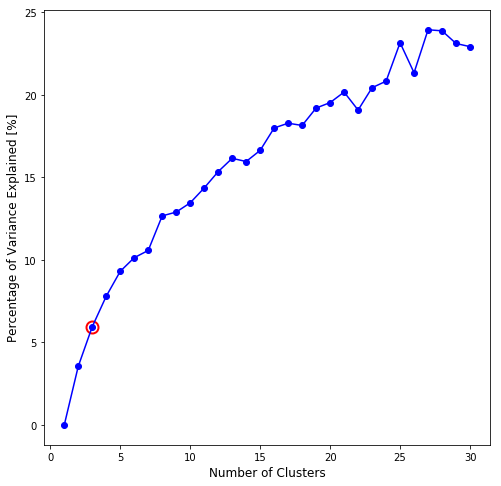

In [47]:
from sklearn.metrics.pairwise import cosine_similarity
def new_euclidean_distances(X, Y=None, Y_norm_squared=None, squared=False): 
    return cosine_sim2(X, Y)

# monkey patch (ensure cosine dist function is used)
from sklearn.cluster import k_means_
k_means_.euclidean_distances = new_euclidean_distances

import matplotlib.pyplot as plt
import seaborn
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics.pairwise import pairwise_distances
from scipy.cluster.hierarchy import fclusterdata

def eblow(data, n):
    print "Performing K-Means..."
    kMeansVar = [KMeans(n_clusters=k, random_state=0).fit(data) for k in range(1, n)]
    print "Done"
    centroids = [X.cluster_centers_ for X in kMeansVar]
    print "Computing Euclidean distances..."
    k_euclid = [cdist(data, cent) for cent in centroids]
    dist = [np.min(ke, axis=1) for ke in k_euclid]
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    print "Done"
    wcss = [sum(d**2) for d in dist]
    print "Computing pairwise distances..."
    pair_dist = pdist(data)
    print "Computing percentage of variance explained..."
    tss = sum(pair_dist**2)/data.shape[0]
    bss = tss - wcss
    percentage_variance = (bss/tss)*100.0
    
    K = range(1,n)
    seg_threshold = 0.95 #Set this to your desired target

    #The angle between three points
    def segments_gain(p1, v, p2):
        vp1 = np.linalg.norm(p1 - v)
        vp2 = np.linalg.norm(p2 - v)
        p1p2 = np.linalg.norm(p1 - p2)
        return np.arccos((vp1**2 + vp2**2 - p1p2**2) / (2 * vp1 * vp2)) / np.pi

    #Normalize the data
    criterion = np.array(avgWithinSS)
    criterion = (criterion - criterion.min()) / (criterion.max() - criterion.min())

    #Compute the angles
    seg_gains = np.array([0, ] + [segments_gain(*
            [np.array([K[j], criterion[j]]) for j in range(i-1, i+2)]
        ) for i in range(len(K) - 2)] + [np.nan, ])

    #Get the first index satisfying the threshold
    kIdx = np.argmax(seg_gains > seg_threshold)
    
    print "Plotting..."
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(K[kIdx], percentage_variance[kIdx], marker='o', markersize=12, 
        markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
    
    ax.scatter(K, percentage_variance, color='b')
    ax.plot(K, percentage_variance, color='b')
    
    ax.set_xlabel("Number of Clusters", fontsize=12)
    ax.set_ylabel("Percentage of Variance Explained [%]", fontsize=12)
    
    print "Minimum number of clusters = ", K[kIdx]
    
    return kMeansVar
    
kMeansVar = eblow(word_vectors, 31)
plt.show()

In [48]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

def matplotlib_to_plotly(cmap, pl_entries):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []
    
    for k in range(pl_entries):
        C = map(np.uint8, np.array(cmap(k*h)[:3])*255)
        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])
        
    return pl_colorscale

def ncols(NUM_COLORS, cmap='gist_rainbow'):
    import matplotlib.cm as mplcm
    import matplotlib.colors as colors
    
    cm = plt.get_cmap(cmap)
    cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
    scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
    return scalarMap

In [49]:
import matplotlib.pyplot as plt
import seaborn
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics.pairwise import pairwise_distances
from scipy.cluster.hierarchy import fclusterdata
from sklearn import decomposition

def cosine_sim(vec1, vec2):
    """
    Computes the cosine similarity between two vectors
    :param vec1:
    :param vec2:
    :return:
    """
    cos_sim = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
    return cos_sim

kOpt = 10
pca3 = decomposition.PCA(n_components=3)
pca_fit3 = pca3.fit(word_vectors)
X = pca_fit3.transform(word_vectors)
words = model.get_labels()

print len(words), len(word_vectors)

NUM_COLORS = kOpt+1
scalarMap = ncols(NUM_COLORS, cmap="jet")

fig = tools.make_subplots(rows=1, cols=1,
                          print_grid=False,
                          specs=[[{'is_3d': True}]])

def similarity(word1, word2, model):
    w1 = model.get_word_vector(word1)
    w2 = model.get_word_vector(word2)
    return cosine_sim(w1, w2)

scene = dict(
    camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=2.5, y=0.1, z=0.1)
    ),
    xaxis=dict(title='pc1',
        gridcolor='rgb(255, 255, 255)',
        zerolinecolor='rgb(255, 255, 255)',
        showbackground=True,
        backgroundcolor='rgb(230, 230,230)',
        showticklabels=False, ticks=''
    ),
    yaxis=dict(title='pc2',
        gridcolor='rgb(255, 255, 255)',
        zerolinecolor='rgb(255, 255, 255)',
        showbackground=True,
        backgroundcolor='rgb(230, 230,230)',
        showticklabels=False, ticks=''
    ),
    zaxis=dict(title='pc3',
        gridcolor='rgb(255, 255, 255)',
        zerolinecolor='rgb(255, 255, 255)',
        showbackground=True,
        backgroundcolor='rgb(230, 230,230)',
        showticklabels=False, ticks=''
    )
)

name,est = ('k_means', KMeans(n_clusters=kOpt, random_state=0).fit(word_vectors))
vector_idx = est.fit_predict(word_vectors)

cols = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

# Add cluster centroids
centroids = pca_fit3.transform(est.cluster_centers_)
# centroidNames = ["Centroid %d" % (i+1) for i in range(kOpt)]

for icluster in range(kOpt):
    idx = np.where(vector_idx == icluster)[0]
    labels = est.labels_[idx]
    data = X[idx]
    
    vec = est.cluster_centers_[icluster]
    name="Centroid %d" % icluster

    text = []
    for ix in idx:
        text.append(words[ix])
    pcols = [cols[icluster]] * len(idx)

    trace = go.Scatter3d(x=data[:, 0], y=data[:, 1], z=data[:, 2],
                         name=name,
                         text=text,
                         showlegend=True,
                         mode='markers',
                         marker=dict(
                                color=pcols[:],
                                line=dict(color='black', width=1)
        ))
    fig.append_trace(trace, 1, 1)
    
    centroidsTrace = go.Scatter3d(x=centroids[icluster, 0], y=centroids[icluster, 1], z=centroids[icluster, 2],
                         name=name,
                         text="Cluster %d" % (icluster+1),
                         showlegend=False,
                         mode='markers',
                         marker=dict(
                                color="black",
                                line=dict(color='black', width=1)
        ))
    fig.append_trace(centroidsTrace, 1, 1)

fig['layout'].update(height=900, width=900,
                     margin=dict(l=10,r=10))

fig['layout']['scene1'].update(scene)
fig['layout']['scene2'].update(scene)
fig['layout']['scene3'].update(scene)
fig['layout']['scene4'].update(scene)
fig['layout']['scene5'].update(scene)

# Use py.iplot() for IPython notebook
py.iplot(fig, filename='3d ONS point clustering')

798 798


In [34]:
ix = np.where(np.array(words) == "__label__gdp")

gdp_cluster = vector_idx[ix][0]
print gdp_cluster

cluster_words_ix = np.where(vector_idx == gdp_cluster)
print cluster_words_ix
cluster_words = np.array(words)[cluster_words_ix]
cluster_vecs = np.array(word_vectors)[cluster_words_ix]
print len(cluster_words), len(cluster_vecs)

5
(array([  1,   5,   6,  10,  11,  12,  13,  48,  58,  69,  79,  87, 107,
       135, 149, 167, 178, 183, 201, 208, 210, 211, 219, 256, 261, 292,
       303, 308, 319, 368, 369, 405, 409, 422, 423, 469, 514, 549, 592,
       600, 601, 602, 603, 618, 628, 664, 665, 666, 669, 690, 732, 733,
       736, 742, 747, 749, 769, 771, 776]),)
59 59


In [50]:
for word in cluster_words:
    print word

__label__gdp
__label__wages
__label__inflation
__label__work
__label__claimants
__label__jobless
__label__salaries
__label__productivity
__label__output
__label__capital
__label__income
__label__qali
__label__trade
__label__students
__label__healthcare
__label__growth
__label__mfp
__label__housing
__label__industrial
__label__efficiency
__label__building
__label__vics
__label__nhs
__label__labour
__label__commercial
__label__stock
__label__tables
__label__opss
__label__real_wages
__label__ppp
__label__oecd
__label__unit
__label__imputed_rental
__label__flow
__label__asset
__label__leps
__label__recession
__label__living_standards
__label__economic_downturn
__label__solow
__label__purchasing_power
__label__employee
__label__deflators
__label__hospitals
__label__workers
__label__colleges
__label__schools
__label__fhs
__label__teachers
__label__awe
__label__sub_regional
__label__urban
__label__devolution
__label__taxes
__label__per
__label__hour
__label__wage
__label__preliminary_estimate